In [2]:
# matplotlib related imports
import matplotlib.pyplot as plt  # for data visualization

# seaborn for statistical data visualization
import seaborn as sns

# numpy, pandas related imports
import numpy as np  # for numerical computations
np.random.seed(123) # setting a random seed for reproducibility of results
import pandas as pd # for data manipulation and analysis

# os and glob for file and directory operations
import os              # for interacting with the OS
from glob import glob  # for creating lists of file paths matching a pattern

# PIL for image operations
from PIL import Image

# for visualisation of true false confusion matrix
import itertools

# scikit-learn related imports
from sklearn.preprocessing import label_binarize     # for converting labels into binary format
from sklearn.metrics import confusion_matrix         # for creating a confusion matrix
from sklearn.model_selection import train_test_split # for splitting data into training and test sets
from sklearn.metrics import classification_report

# tensorflow related import
import tensorflow as tf

# keras related imports
import keras                                        # for deep learning
from keras.models import Sequential, load_model     # for creating a sequential model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU  # various layers for the model
from keras.optimizers import SGD, Adam              # for the Adam optimizer
from keras.callbacks import ReduceLROnPlateau       # to reduce learning rate when a metric has stopped improving
from keras.preprocessing.image import ImageDataGenerator # for real-time data augmentation
from keras import backend as K                      # for operations with the keras backend
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical              # for converting class vector (integers) to binary class matrix


### Data Preprocessing 

this is used to create a Dataframe for the data and also cleaning, making the data much more useable and readable 

***


Insuring correct directory

In [3]:
os.listdir('../.input')

['category_samples.png',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'model.h5']

Setting directory with os path as var for use in dataframe

In [4]:
# Set the directory path for the skin image dataset
base_skin_dir = os.path.join('..', '.input')
print(base_skin_dir)

..\.input


Creating a dictionary of the image paths for the dataset 

In [5]:
# Create a dictionary that maps each image ID to its respective file path.
# We use a dictionary comprehension where the keys are the base names of the images 
# (i.e., the image file name without the .jpg extension) and the values are the image paths.
# The glob function is used to get all .jpg image file paths from the base_skin_dir.

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

Creation of a Dictionary for the leison types found in the dataset

In [6]:
# Create a dictionary that maps each lesion type code to its full name. 
# This is useful for displaying more human-friendly labels later on.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Reading CSV into the dataframe

In [7]:
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

adding further creating new columns in the data frame we have made from the previous dictionaries for the image path and the leison type 

In [8]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

unique_cell_type_idxs = df['cell_type_idx'].unique()
for idx in unique_cell_type_idxs:
    cell_type = df[df['cell_type_idx'] == idx]['cell_type'].iloc[0]
    print(f"Index: {idx}, Cell Type: {cell_type}")


Index: 2, Cell Type: Benign keratosis-like lesions 
Index: 4, Cell Type: Melanocytic nevi
Index: 3, Cell Type: Dermatofibroma
Index: 5, Cell Type: Melanoma
Index: 6, Cell Type: Vascular lesions
Index: 1, Cell Type: Basal cell carcinoma
Index: 0, Cell Type: Actinic keratoses


displaying the dataframe to ensure we have correctly read the columns and added new columns we have made into the dataframe

In [9]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ..\.input\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ..\.input\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ..\.input\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ..\.input\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ..\.input\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

Checking for NULL data values in the dataset so we can replace them

In [10]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

/\ after finding the null values in age above we move on to create averages to replace these variables as they cannot be read by the model as NULL /\

***

below we follow on from this creating means of the age from the NULL values

In [11]:
df['age'].fillna((df['age'].mean()), inplace=True)

Re-checking for null variables in the dataset

In [12]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

Loading and resizing of images into the dataframe

In [13]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

Checking if the dataframe is updated with the image column

In [14]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ..\.input\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ..\.input\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ..\.input\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ..\.input\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ..\.input\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[190, 153, 194], [192, 154, 196], [191, 153,...  
1  [[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3...  
2  [[[185, 127, 137], [189, 133, 147], [194, 136,...  
3  [[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5...  
4  [[[134, 90, 113], [147, 102, 125], [159, 115, ...

checcking the value coutns of the images

In [15]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

plotting some images to view at random with top row being one random from each and bottom being a random image form the entire dataset

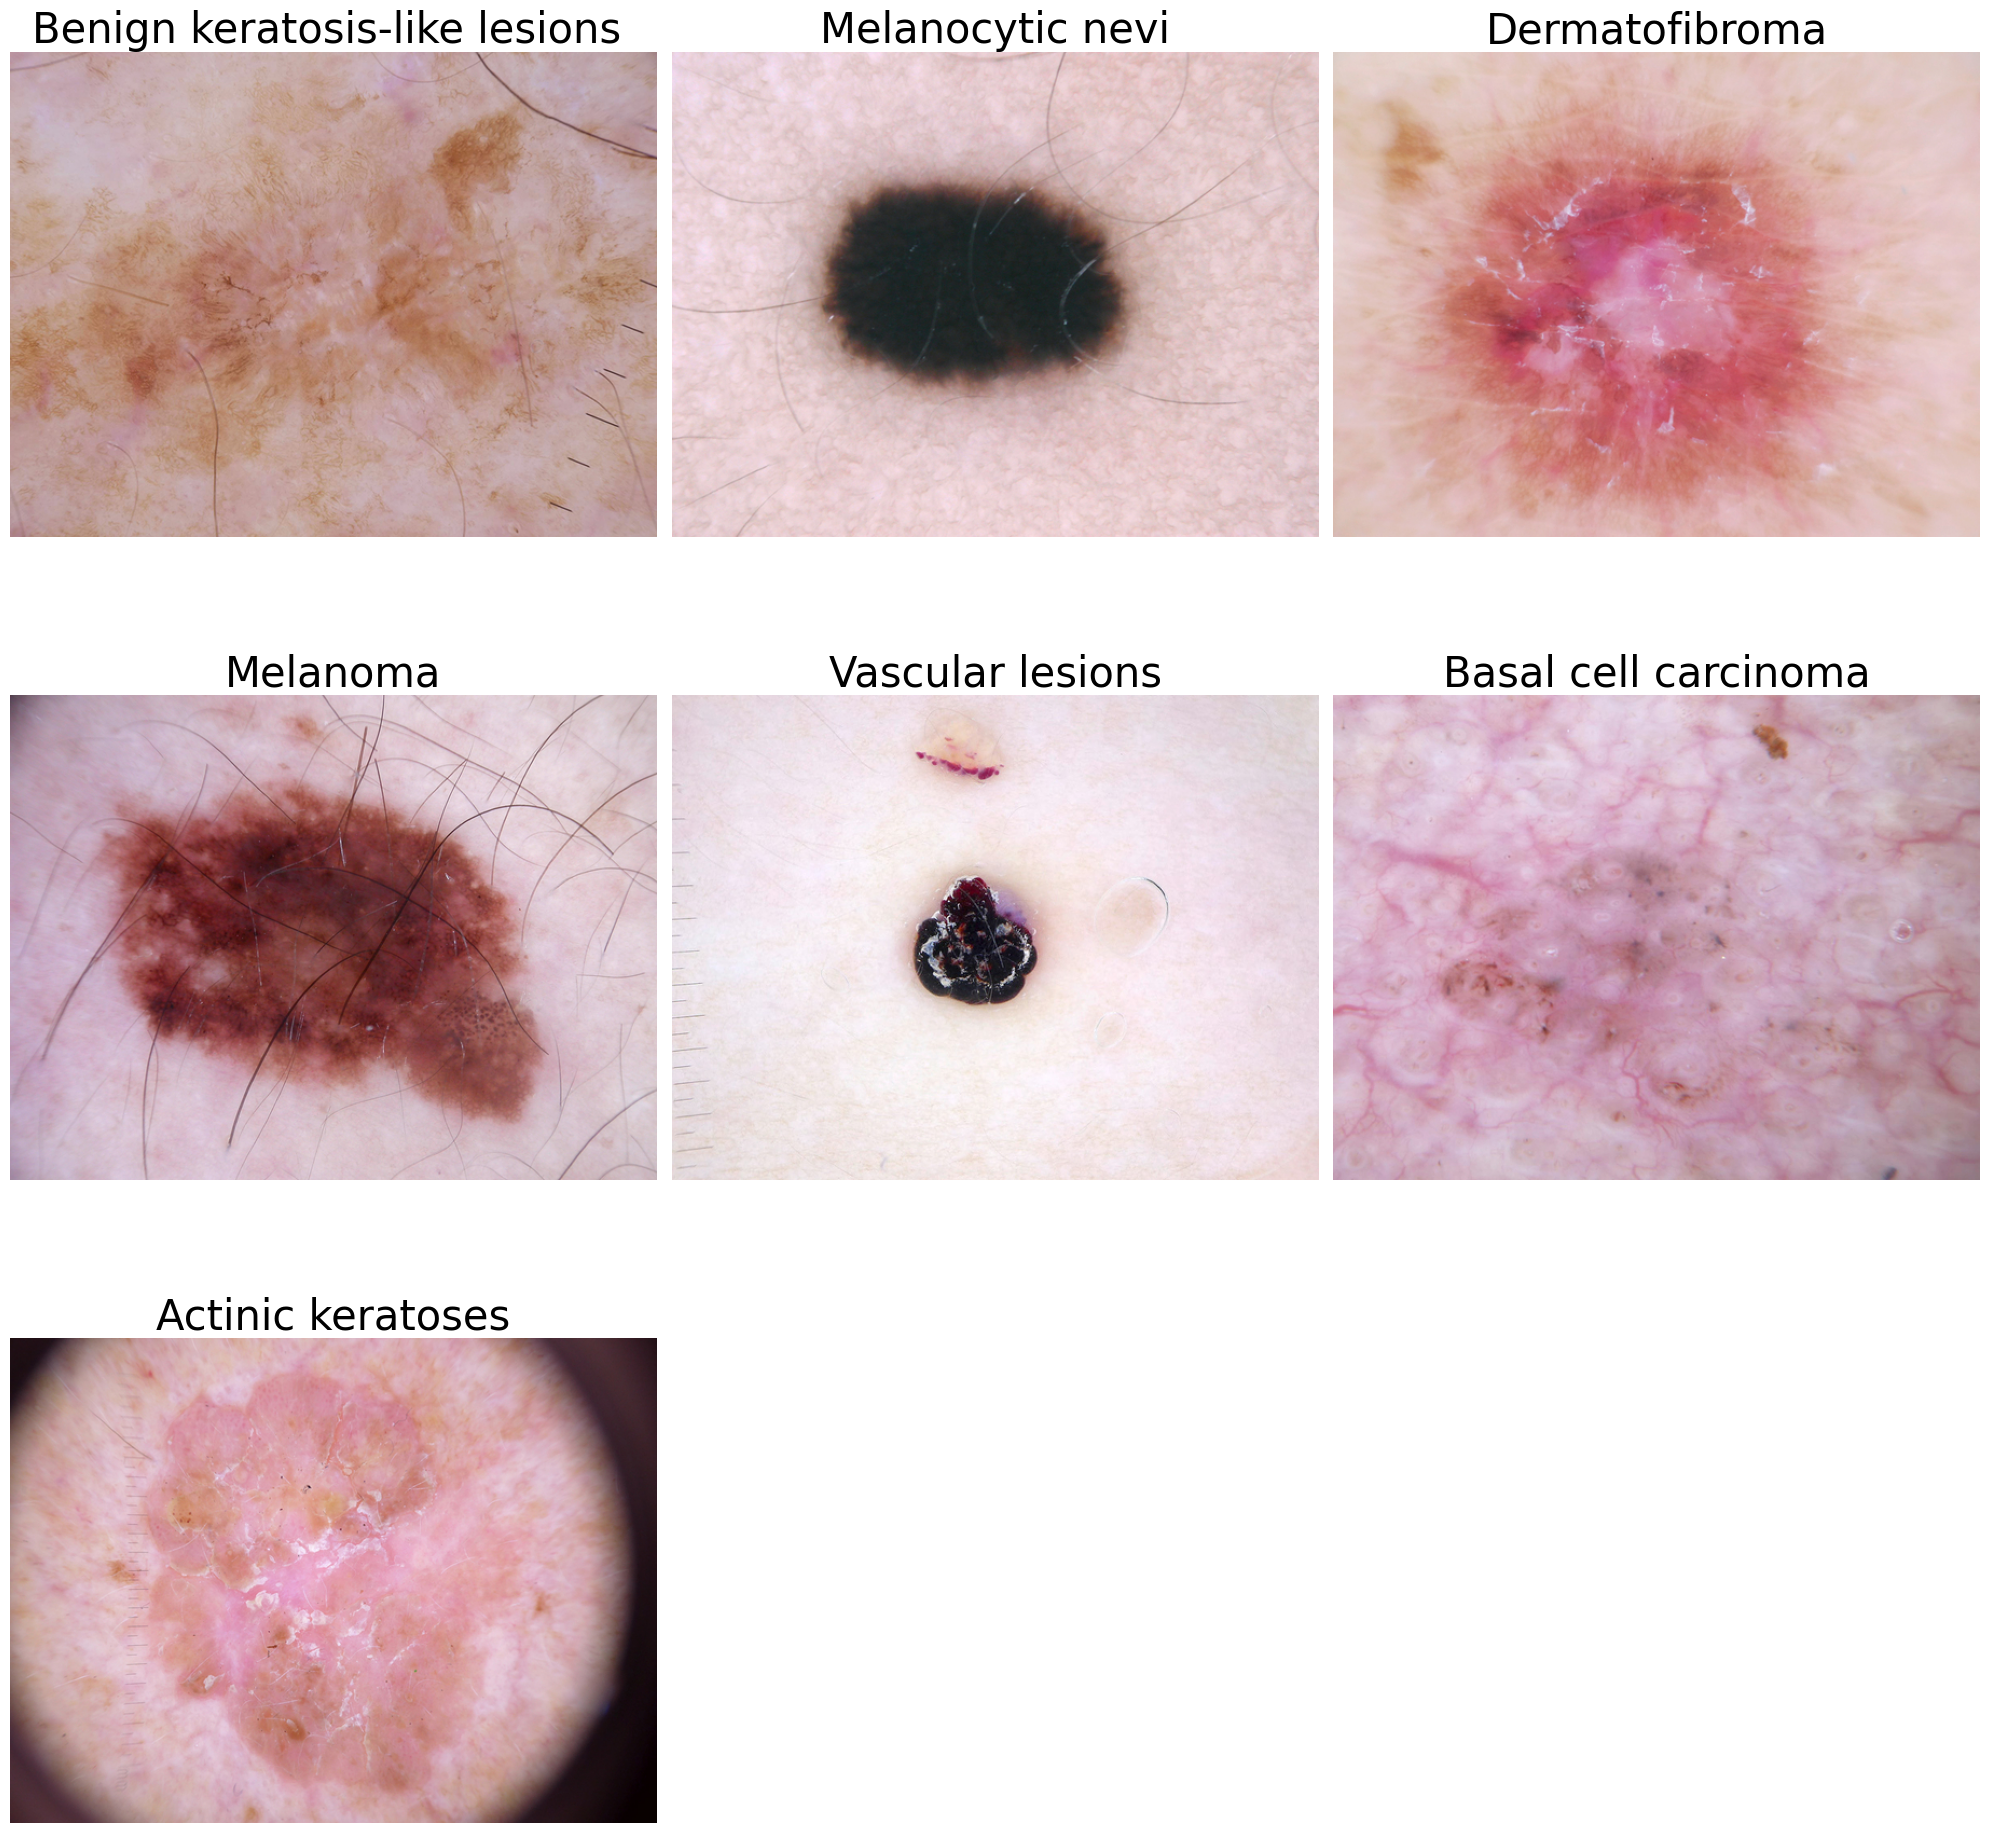

In [19]:
import math

unique_cell_types = df['cell_type'].unique()

# Calculate the grid size: grid_size x grid_size
grid_size = math.ceil(math.sqrt(len(unique_cell_types)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

for i, cell_type in enumerate(unique_cell_types):
    random_sample = df[df['cell_type'] == cell_type].sample(1)
    image = Image.open(random_sample['path'].values[0])

    # Calculate subplot position
    row = i // grid_size
    col = i % grid_size

    axs[row, col].imshow(image)
    axs[row, col].set_title(random_sample['cell_type'].values[0], fontsize=30)  # increase fontsize here
    axs[row, col].axis('off')

# Remove empty subplots
if len(unique_cell_types) < grid_size**2:
    for i in range(len(unique_cell_types), grid_size**2):
        fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.savefig("C:/Users/ethan/Documents/GitHub/DSP/Project/cells/cell_types.png", bbox_inches='tight')
plt.show()
